In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error
from scipy.signal import argrelextrema

In [83]:
# Variabili globali

path = 'pala_ok/fullDischargeGoodmotor/'

In [84]:
allacqui_NI = []
allacqui_RPM = []
allacqui_Volts = []

# Andiamo a prendere tutti i path dei vari file
path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


In [85]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,len(path_acquisizioni))):
    if("NI" in a):
        try:
            allacqui_NI.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
        except:
            allacqui_NI.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['Time'],keep='last',ignore_index=True))
    elif("RPM" in a):
        allacqui_RPM.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    elif("Volts" in a):
        allacqui_Volts.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))


(10390,)
(10390,)
(10390,)



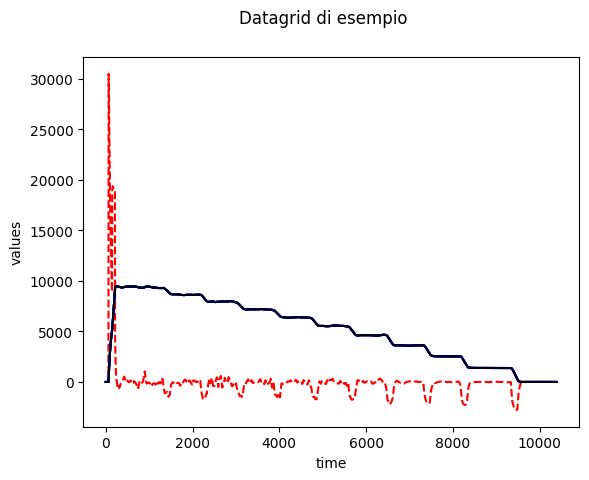

In [86]:
## Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media
RpmMean = allacqui_RPM[1]['rpm'].rolling(150,min_periods = 1,center=False).mean()
grid_points = []
data_matrix = np.array(RpmMean)
grid_points = np.arange(RpmMean.shape[0])
gradient = np.gradient(RpmMean,grid_points)
gradient = gradient*300
rollmax = np.array(pd.DataFrame(gradient).rolling(150,min_periods = 1,center=False).max())[:,0]
print(grid_points.shape)
print(gradient.shape)
print(rollmax.shape)

fd_manu = skfda.FDataGrid(
    data_matrix=np.array([data_matrix,gradient]),
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=1)
)
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
print()

c:\Users\Leo\.conda\envs\manu2\lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
c:\Users\Leo\.conda\envs\manu2\lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


Index([1493, 2346, 3174, 4033, 4894, 5759, 6627, 7491, 8344, 9507], dtype='int64')


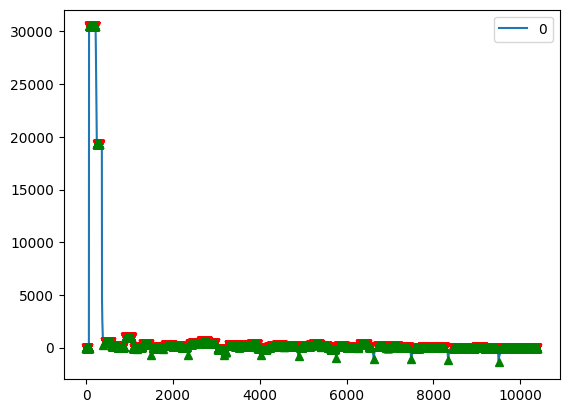

In [87]:
rollmaxDataframe = pd.DataFrame(rollmax)
ilocs_min = argrelextrema(rollmax, np.less_equal, order=10)[0]
ilocs_max = argrelextrema(rollmax, np.greater_equal, order=10)[0]
rollmaxDataframe.plot()
rollmaxDataframe.iloc[ilocs_max][0].plot(style='.', lw=10, color='red', marker="v")
rollmaxDataframe.iloc[ilocs_min][0].plot(style='.', lw=10, color='green', marker="^")

index = rollmaxDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
print(index)

In [88]:
def getpwnmap(x):
    res = 100
    for i in index:
        if x>i:
            res = res-10
    return res

In [89]:
ranges = allacqui_RPM[1].index
maxindex = rollmaxDataframe.iloc[ilocs_min].nlargest(1,0, keep='first').index[0]
pwm = list(map(getpwnmap,list(ranges)))
pwm[:maxindex] = [0] * (len(pwm) - maxindex)
print(maxindex)


77


In [90]:
def getPWM(DataFrameRPM):
    #Get PWN of RPM/Battery
    DataFrameMean = DataFrameRPM['rpm'].rolling(150,min_periods = 1,center=False).mean()
    gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))
    rollmax = np.array(pd.DataFrame(gradient).rolling(150,min_periods = 1,center=False).max())[:,0]
    rollmaxDataframe = pd.DataFrame(rollmax)
    ilocs_min = argrelextrema(rollmax, np.less_equal, order=10)[0]
    ilocs_max = argrelextrema(rollmax, np.greater_equal, order=10)[0]
    Minindexes = rollmaxDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
    def genpwm(x):
        res = 100
        for i in Minindexes:
            if x>i:
                res = res-10
        return res
    ranges = DataFrameRPM.index
    maxindex = rollmaxDataframe.iloc[ilocs_max].nlargest(1,0, keep='first')
    print(maxindex.index[0])
    pwmRPM = list(map(genpwm,list(ranges)))
    pwmRPM[:maxindex.index[0]] = [0] * (maxindex.index[0])
    
    ##Get PWN of NationalInstrument
    #timestamps = DataFrameRPM.iloc[Minindexes].time
    #
    #def genpwmNI(x):
    #    res = 100
    #    for i in timestamps:
    #        if x>i:
    #            res = res-10
    #    return res
    #pwmNI = []
    #maxtime = DataFrameRPM.iloc[maxindex.index[0]].time
    #maxtimeindex = DataframeNI[DataframeNI['time'] == list(filter(lambda i: i > maxtime, DataframeNI['time']))[0]].index[0]
    #pwmNI = list(map(genpwmNI,list(DataframeNI.time)))
    #pwmNI[:maxtimeindex] = [0] * (len(pwmNI) - maxtimeindex)
    
    return pwmRPM
    

In [91]:
RpmPWN = getPWM(allacqui_RPM[1])
RPMcsv = pd.DataFrame(RpmPWN)
pd.set_option('display.max_rows', RPMcsv.shape[0]+1)

print(RPMcsv)

67
         0
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67     100
68     100
69     100
70     100
71     100
72     100
73     100
74     100
75     100
76     100
77     100
78     100
79     100
80     100
81     100
82     100
83     100
84     100
85     100
86     100
87     100
88     100
89     